# Load Dataset


In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging
import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

from torch.utils.data import TensorDataset, random_split

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

In [ ]:
def listPaths(path):
  pathfiles = list()
  for pathfile in glob.glob(path):
    pathfiles.append(pathfile)
  return pathfiles

In [ ]:
import glob
import pandas as pd

data_pathsXe = listPaths('/content/gdrive/MyDrive/data3/Xe/*')
data_pathsTuongThuat = listPaths('/content/gdrive/MyDrive/data3/TuongThuat/*')
data_pathsThoiSu = listPaths('/content/gdrive/MyDrive/data3/ThoiSu/*')
data_pathsTheThao = listPaths('/content/gdrive/MyDrive/data3/TheThao/*')
data_pathsTheGioi = listPaths('/content/gdrive/MyDrive/data3/TheGioi/*')
data_pathsSucKhoe = listPaths('/content/gdrive/MyDrive/data3/SucKhoe/*')
data_pathsSoHoa = listPaths('/content/gdrive/MyDrive/data3/SoHoa/*')
data_pathsPhapLuat = listPaths('/content/gdrive/MyDrive/data3/PhapLuat/*')
data_pathsKinhDoanh = listPaths('/content/gdrive/MyDrive/data3/KinhDoanh/*')
data_pathsKhoaHoc = listPaths('/content/gdrive/MyDrive/data3/KhoaHoc/*')
data_pathsHai = listPaths('/content/gdrive/MyDrive/data3/Hai/*')
data_pathsGocNhin = listPaths('/content/gdrive/MyDrive/data3/GocNhin/*')
data_pathsGiaoDuc = listPaths('/content/gdrive/MyDrive/data3/GiaoDuc/*')
data_pathsGiaiTri = listPaths('/content/gdrive/MyDrive/data3/GiaiTri/*')
data_pathsDuLich = listPaths('/content/gdrive/MyDrive/data3/DuLich/*')
data_pathsDoiSong = listPaths('/content/gdrive/MyDrive/data3/DoiSong/*')

In [ ]:
def read_content(pathfile):
  with open(pathfile) as f:
    rows  = f.readlines()
    original = ' '.join(''.join(rows[2:]).split('\n'))         
  return {'title' : rows,
            'original': original}

In [ ]:
def get_dataframe(pathfiles):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    data = executor.map(read_content, pathfiles)
  
  # Make blank dataframe
  data_df = list()
  for d in data:
    data_df.append(d)
  data_df = pd.DataFrame(data_df)
  data_df.dropna(inplace = True)
  data_df = data_df.sample(frac=1).reset_index(drop=True)

  return data_df

In [ ]:
df1 = get_dataframe(data_pathsXe)
df2 = get_dataframe(data_pathsTuongThuat)#bỏ
df3 = get_dataframe(data_pathsThoiSu)
df4 = get_dataframe(data_pathsTheThao)
df5 = get_dataframe(data_pathsTheGioi)
df6 = get_dataframe(data_pathsSucKhoe)
df7 = get_dataframe(data_pathsSoHoa)
df8 = get_dataframe(data_pathsPhapLuat)
df9 = get_dataframe(data_pathsKinhDoanh)
df10 = get_dataframe(data_pathsKhoaHoc)
df11 = get_dataframe(data_pathsHai)
df12 = get_dataframe(data_pathsGocNhin)
df13 = get_dataframe(data_pathsGiaoDuc)
df14 = get_dataframe(data_pathsGiaiTri)
df15 = get_dataframe(data_pathsDuLich)
df16 = get_dataframe(data_pathsDoiSong)

In [ ]:
df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16])

In [ ]:
df = df.sample(frac = 1).reset_index(drop=True)

In [ ]:
new_column = pd.Series(["DoiSong"] * len(df16))

df16["label"] = new_column

In [ ]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     611 non-null    object
 1   original  611 non-null    object
 2   label     611 non-null    object
dtypes: object(3)
memory usage: 14.4+ KB


In [ ]:
df.to_csv('/content/gdrive/MyDrive/Thư mục không có tiêu đề/df_data.csv', index=False)

In [ ]:
df.sample(10)

,title,original,label
328,[Xe tải đi thẳng va chạm với xe con rẽ trái - ...,Hải DươngÔtô màu đỏ dừng lại trước đèn giao th...,Xe
4218,"[Elon Musk đặt tham vọng 'siêu ứng dụng' X \n,...",Musk cho biết ông có kế hoạch biến Twitter thà...,SoHoa
5572,"[Học Hoá vô cơ thì nên du học ở đâu? \n, \n, L...","Là sinh viên ngành Hoá vô cơ, trường Đại học B...",GiaoDuc
474,"[1,news1.txt,https://vnexpress.net/hoi-tuong-q...","3,news3.txt,https://vnexpress.net/khach-viet-m...",DuLich
7417,[Năm điều khiến nữ thạc sĩ người Việt nuối tiế...,"Không rèn luyện tư duy tài chính cá nhân, kết ...",GiaoDuc
6072,[Phát hiện mảnh vỡ lớn nhất từ thảm họa tàu co...,MỹMảnh vỡ lớn nhất từ tàu con thoi Challenger ...,KhoaHoc
4458,"[Thùy Dung làm đám cưới vào tháng 12 \n, \n, Á...",Á hậu Thùy Dung và bạn trai sẽ tổ chức đám cướ...,GiaiTri
2774,"[Thoát vị đĩa đệm có thể tự khỏi không? \n, \n...",Nếu thoát vị đĩa đệm chưa gây chèn ép rễ thần ...,SucKhoe
762,"[Vị chúa Trịnh cuối cùng của nước ta là ai?\n,...",Có 11 đời chúa Trịnh chính thức cai quản xứ Đà...,Hai
4795,[Cuộc chiến pháp lý giữa người mắc ung thư với...,"MỹTrước năm 1950, các tập đoàn thuốc lá khẳng ...",PhapLuat


In [ ]:
n_rows = df.shape[0]

# Chia DataFrame thành 3 phần theo tỉ lệ 80-10-10
train_df = df.iloc[:int(0.8 * n_rows), :]
val_df = df.iloc[int(0.8 * n_rows):int(0.9 * n_rows), :]
test_df = df.iloc[int(0.9 * n_rows):, :]

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6280 entries, 0 to 6279
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     6280 non-null   object
 1   original  6280 non-null   object
 2   label     6280 non-null   object
dtypes: object(3)
memory usage: 147.3+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 7065 to 7849
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     785 non-null    object
 1   original  785 non-null    object
 2   label     785 non-null    object
dtypes: object(3)
memory usage: 18.5+ KB


In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 6280 to 7064
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     785 non-null    object
 1   original  785 non-null    object
 2   label     785 non-null    object
dtypes: object(3)
memory usage: 18.5+ KB


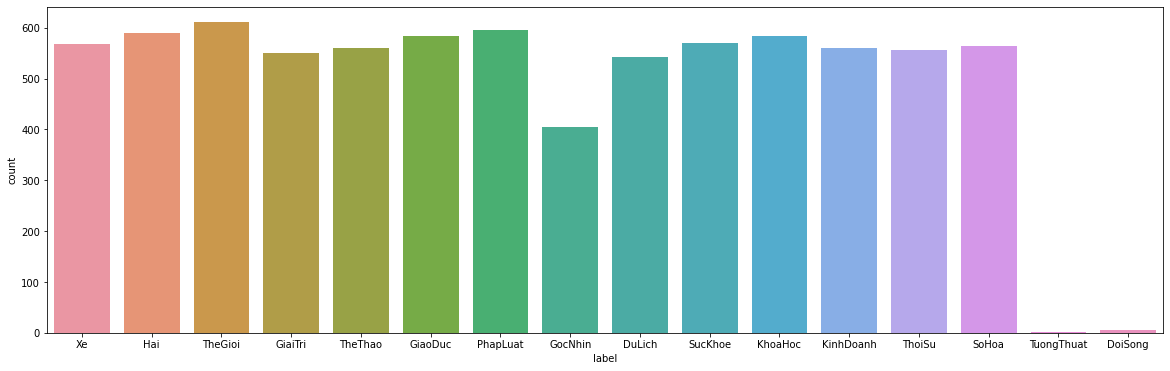

In [ ]:
plt.figure(figsize=(20, 6))
sns.countplot(x='label', data=df , orient='h')
plt.show()

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoModel, AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='Xe':
            return 0
        elif text=='Hai':
            return 1
        elif text=='TheGioi':
            return 2
        elif text=='GiaiTri':
            return 3
        elif text=='TheThao':
            return 4
        elif text=='GiaoDuc':
            return 5
        elif text=='PhapLuat':
            return 6
        elif text=='GocNhin':
            return 7
        elif text=='DuLich':
            return 8
        elif text=='SucKhoe':
            return 9
        elif text=='KhoaHoc':
            return 10 
        elif text=='KinhDoanh':
            return 11
        elif text=='ThoiSu':
            return 12
        elif text=='SoHoa':
            return 13
        elif text=='TuongThuat':
            return 14
        elif text=='DoiSong':
            return 15   
        else:
            return 

    def get_input_data(self, row):
        text = row['original']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['Emotion'])

        return text, label

In [ ]:
from gensim.utils import simple_preprocess

Text(0.5, 6.79999999999999, 'Token Count')

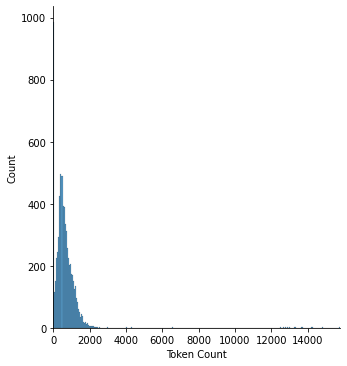

In [ ]:
# Distribution of length of Sentence
all_data = train_df.original.tolist() + test_df.original.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [ ]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ClassifierDataset(df_train, tokenizer, max_len=120)
    valid_dataset = ClassifierDataset(df_valid, tokenizer, max_len=120)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

In [ ]:
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.label)):
    train_df.loc[val_, "kfold"] = fold

In [ ]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=16).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------


Epoch 1/6
------------------------------
Train Accuracy: 0.5495621019108281 Loss: 1.8476701581933697
Valid Accuracy: 0.8248407643312102 Loss: 1.0124760911434512
Epoch 2/6
------------------------------
Train Accuracy: 0.8662420382165605 Loss: 0.7641533300944954
Valid Accuracy: 0.8726114649681529 Loss: 0.5813085729185539
Epoch 3/6
------------------------------
Train Accuracy: 0.9239649681528663 Loss: 0.40328915198897103
Valid Accuracy: 0.89171974522293 Loss: 0.4623512172057659
Epoch 4/6
------------------------------
Train Accuracy: 0.955015923566879 Loss: 0.2404085732877824
Valid Accuracy: 0.8789808917197452 Loss: 0.464037970887332
Epoch 5/6
------------------------------
Train Accuracy: 0.9725318471337581 Loss: 0.14800101319909287
Valid Accuracy: 0.8909235668789809 Loss: 0.4704656263789799
Epoch 6/6
------------------------------
Train Accuracy: 0.9806926751592357 Loss: 0.11306337190637733
Valid Accuracy: 0.9004777070063694 Loss: 0.4558346784331753
-----------Fold: 2 ----------------

In [ ]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=16)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [ ]:
test_dataset =  SentimentDataset(test_df,tokenizer, max_len=120)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

NameError: ignored

In [ ]:
class_names = ['Xe','Hai','TheGioi','GiaiTri','TheThao','GiaoDuc','PhapLuat','GocNhin','DuLich','SucKhoe','KhoaHoc','KinhDoanh','ThoiSu','SoHoa','TuongThuat','DoiSong']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

NameError: ignored